# W266 Final Project

Authors: Satheesh Joseph, Catherine Mou, Yi Zhang

# Part 1: Downloading and preparing the data

We acquired the dataset from the researchers in the form of Sqlite `.db` files.

In [1]:
# Imports
import os, sys, re, json, time, unittest
import itertools, collections
from importlib import reload
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime

import numpy as np
from scipy import stats
import pandas as pd
import sqlite3
import unicodedata
import nltk

import tensorflow as tf
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, Lambda, Bidirectional, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, InputLayer, Embedding
from tensorflow.keras.layers import TextVectorization
import tensorflow_text as text  # Registers the ops.

from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_hub as hub

import tensorflow.keras as keras
from tensorflow.python.keras import utils

In [2]:
# Download the files if they're not here
if 'data' not in os.listdir('.') or not os.listdir('data'):
    os.system('wget https://storage.googleapis.com/mids-w266-final-project-data/yelpHotelData.db -P data/')
    os.system('wget https://storage.googleapis.com/mids-w266-final-project-data/yelpResData.db -P data/')
    print('Data downloaded successfully!')
else:
    print('Already downloaded data')

Already downloaded data


In [3]:
# Load data from the database
con = sqlite3.connect('data/yelpResData.db')
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

con = sqlite3.connect('data/yelpHotelData.db')
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('review',), ('restaurant',), ('reviewer',)]
[('review',), ('sqlite_stat1',), ('sqlite_stat2',), ('reviewer',), ('hotel',)]


In [4]:
# Reading from the hotels database
hotels_db = sqlite3.connect("data/yelpHotelData.db")
hotels = pd.read_sql_query("SELECT * FROM hotel", hotels_db)
hotel_reviews = pd.read_sql_query("SELECT * FROM review WHERE flagged in ('Y', 'N')", hotels_db)
hotel_reviewers = pd.read_sql_query("SELECT * FROM reviewer", hotels_db)

print(f'The data set contains {len(hotel_reviews)} reviews, and {len(hotel_reviewers)} reviewers')

The data set contains 5858 reviews, and 5123 reviewers


In [5]:
# Reading from the restaurant database
restaurant_db = sqlite3.connect("data/yelpResData.db")
restaurant_db.text_factory = lambda x: x.decode("utf-8", errors='ignore')
restaurants = pd.read_sql_query("SELECT * FROM restaurant", restaurant_db)
restaurant_reviews = pd.read_sql_query("SELECT * FROM review WHERE flagged in ('Y', 'N')", restaurant_db)
restaurant_reviewers = pd.read_sql_query("SELECT * FROM reviewer", restaurant_db)

print(f'The data set contains {len(restaurant_reviews)} reviews, and {len(restaurant_reviewers)} reviewers')

The data set contains 67019 reviews, and 16941 reviewers


In [6]:
# Data Cleaning
hotel_reviews['reviewContent'] = hotel_reviews['reviewContent'].apply(lambda x: unicodedata.normalize('NFKD', x))
hotel_reviews['date'] = hotel_reviews['date'].apply(lambda x: datetime.datetime.strptime(x.strip().split(' ')[-1], '%m/%d/%Y'))

restaurant_reviews['reviewContent'] = restaurant_reviews['reviewContent'].apply(lambda x: unicodedata.normalize('NFKD', x))
restaurant_reviews['date'] = restaurant_reviews['date'].apply(lambda x: datetime.datetime.strptime(x.strip().split(' ')[-1], '%m/%d/%Y'))


In [7]:
# Split data according to the research paper, i.e. balanced new reviews after 2012-01-01
hotel_X_test = hotel_reviews[hotel_reviews['date'] >= datetime.datetime(2012, 1, 1)]
hotel_X_test = hotel_X_test.sort_values('date', ignore_index=True).groupby('reviewerID', as_index=False).first()
hotel_X_test_positive = hotel_X_test[hotel_X_test['flagged'] == 'Y']
hotel_X_test_negative = hotel_X_test[hotel_X_test['flagged'] == 'N']
hotel_X_test_balanced = pd.concat([hotel_X_test_positive, hotel_X_test_negative.sample(n=len(hotel_X_test_positive))], ignore_index=True)
hotel_X_test = hotel_X_test_balanced.sample(frac=1)
hotel_y_test = hotel_X_test_balanced['flagged'] == 'Y'
hotel_X_train_and_dev = hotel_reviews[hotel_reviews['date'] < datetime.datetime(2012, 1, 1)]
hotel_X_train, hotel_X_dev, hotel_y_train, hotel_y_dev = train_test_split(hotel_X_train_and_dev, hotel_X_train_and_dev['flagged']=='Y')

restaurant_X_test = restaurant_reviews[restaurant_reviews['date'] >= datetime.datetime(2012, 1, 1)]
restaurant_X_test = restaurant_X_test.sort_values('date', ignore_index=True).groupby('reviewerID', as_index=False).first()
restaurant_X_test_positive = restaurant_X_test[restaurant_X_test['flagged'] == 'Y']
restaurant_X_test_negative = restaurant_X_test[restaurant_X_test['flagged'] == 'N']
restaurant_X_test_balanced = pd.concat([restaurant_X_test_positive, restaurant_X_test_negative.sample(n=len(restaurant_X_test_positive))], ignore_index=True)
restaurant_X_test = restaurant_X_test_balanced.sample(frac=1)
restaurant_y_test = restaurant_X_test_balanced['flagged'] == 'Y'
restaurant_X_train_and_dev = restaurant_reviews[restaurant_reviews['date'] < datetime.datetime(2012, 1, 1)]
restaurant_X_train, restaurant_X_dev, restaurant_y_train, restaurant_y_dev = train_test_split(restaurant_X_train_and_dev, restaurant_X_train_and_dev['flagged']=='Y')


# Part 2: Exploratory Data Analysis

In [8]:
hotel_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3402 entries, 1604 to 319
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           3402 non-null   datetime64[ns]
 1   reviewID       3402 non-null   object        
 2   reviewerID     3402 non-null   object        
 3   reviewContent  3402 non-null   object        
 4   rating         3402 non-null   int64         
 5   usefulCount    3402 non-null   int64         
 6   coolCount      3402 non-null   int64         
 7   funnyCount     3402 non-null   int64         
 8   flagged        3402 non-null   object        
 9   hotelID        3402 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 292.4+ KB


In [9]:
restaurant_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42086 entries, 10524 to 47798
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           42086 non-null  datetime64[ns]
 1   reviewID       42086 non-null  object        
 2   reviewerID     42086 non-null  object        
 3   reviewContent  42086 non-null  object        
 4   rating         42086 non-null  int64         
 5   usefulCount    42086 non-null  int64         
 6   coolCount      42086 non-null  int64         
 7   funnyCount     42086 non-null  int64         
 8   flagged        42086 non-null  object        
 9   restaurantID   42086 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 3.5+ MB


In [10]:
reviews = pd.concat([restaurant_X_train, hotel_X_train.rename(columns={'hotelID':'restaurantID'})], ignore_index=True)
reviews.groupby('reviewerID').agg({"usefulCount": np.sum, 
                                   "coolCount": np.sum, 
                                   "funnyCount": np.sum}).sort_values(by=['usefulCount'], ascending=False)
reviews[reviews['reviewerID'] == 'w-w-k-QXosIKQ8HQVwU6IQ']['reviewContent']

15052    ***Alinea is truly a one-of-a-kind experience;...
39211    ***Longman & Eagle is a true gastropub--a casu...
39524    ***Graham Elliot serves up refined casual food...
Name: reviewContent, dtype: object

In [11]:
reviews.groupby('flagged').agg('sum')

,rating,usefulCount,coolCount,funnyCount
flagged,,,,
N,158255,44474,29420,25257
Y,21366,0,0,0


,date,reviewID,reviewerID,reviewContent,usefulCount,coolCount,funnyCount,flagged,restaurantID
rating,,,,,,,,,
1,1438,1438,1438,1438,1438,1438,1438,1438,1438
2,2853,2853,2853,2853,2853,2853,2853,2853,2853
3,5849,5849,5849,5849,5849,5849,5849,5849,5849
4,15376,15376,15376,15376,15376,15376,15376,15376,15376
5,14412,14412,14412,14412,14412,14412,14412,14412,14412


(array([ 1438.,     0.,  2853.,     0.,     0.,  5849.,     0., 15376.,
            0., 14412.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

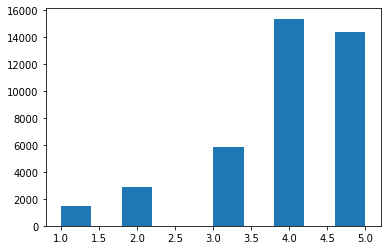

In [12]:
trueReviews = reviews[reviews['flagged'] == 'N']
fakeReviews = reviews[reviews['flagged'] == 'Y']
display(trueReviews.groupby('rating').agg('count'))
plt.hist(x=trueReviews.rating, bins=10)

,date,reviewID,reviewerID,reviewContent,usefulCount,coolCount,funnyCount,flagged,restaurantID
rating,,,,,,,,,
1,659,659,659,659,659,659,659,659,659
2,433,433,433,433,433,433,433,433,433
3,510,510,510,510,510,510,510,510,510
4,1479,1479,1479,1479,1479,1479,1479,1479,1479
5,2479,2479,2479,2479,2479,2479,2479,2479,2479


(array([ 659.,    0.,  433.,    0.,    0.,  510.,    0., 1479.,    0.,
        2479.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

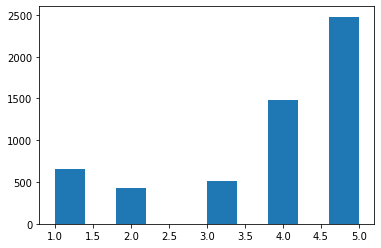

In [13]:
display(fakeReviews.groupby('rating').agg('count'))
plt.hist(x=fakeReviews.rating, bins=10)

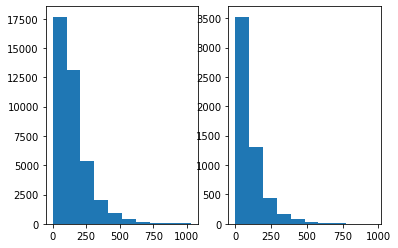

In [14]:
plt.subplot(1, 2, 1)
plt.hist(x = trueReviews['reviewContent'].str.count(' ') + 1)
plt.subplot(1, 2, 2)
plt.hist(x = fakeReviews['reviewContent'].str.count(' ') + 1)
plt.show()

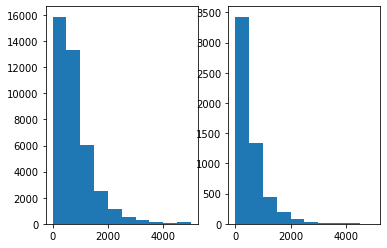

In [15]:
plt.subplot(1, 2, 1)
plt.hist(x = trueReviews['reviewContent'].str.count('.') + 1)
plt.subplot(1, 2, 2)
plt.hist(x = fakeReviews['reviewContent'].str.count('.') + 1)
plt.show()

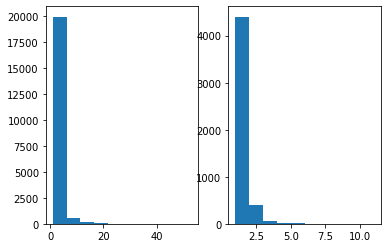

In [16]:
trueReviewerCounts = trueReviews.groupby(['reviewerID']).size().reset_index(name='counts')
fakeReviewerCounts = fakeReviews.groupby(['reviewerID']).size().reset_index(name='counts')


plt.subplot(1, 2, 1)
plt.hist(x = trueReviewerCounts['counts'], bins=10)
plt.subplot(1, 2, 2)
plt.hist(x = fakeReviewerCounts['counts'], bins=10)
plt.show()


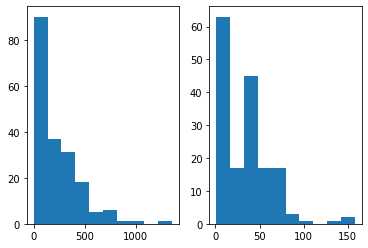

In [17]:
trueRestReviewCounts = trueReviews.groupby(['restaurantID']).size().reset_index(name='counts')
fakeRestReviewCounts = fakeReviews.groupby(['restaurantID']).size().reset_index(name='counts')


plt.subplot(1, 2, 1)
plt.hist(x = trueRestReviewCounts['counts'], bins=10)
plt.subplot(1, 2, 2)
plt.hist(x = fakeRestReviewCounts['counts'], bins=10)
plt.show()


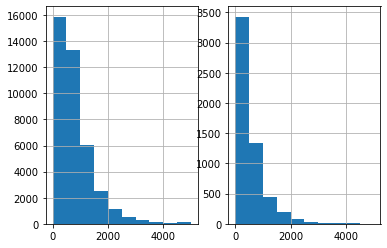

In [18]:
plt.subplot(1, 2, 1)
trueReviews['reviewContent'].str.len().hist()
plt.subplot(1, 2, 2)
fakeReviews['reviewContent'].str.len().hist()
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yizhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


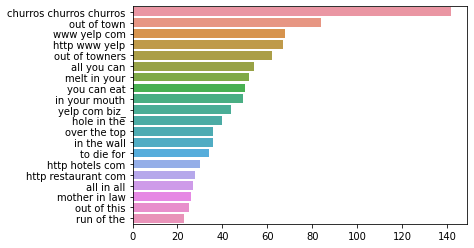

In [19]:
# Code Snippet for Top N-grams Barchart

import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

nltk.download('stopwords')

def plot_top_ngrams_barchart(text, n=2):
    synthetic = {'gmail', 'they', 'http', 'www'}
    stop=set(stopwords.words('english')) | synthetic
    new= text.str.split()
    new= new.values.tolist()
    corpus=[word for i in new for word in i if word.lower() not in stop]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:20]

    top_n_bigrams=_get_top_ngram(corpus,n)[:20]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)
    

plot_top_ngrams_barchart(trueReviews['reviewContent'],3)

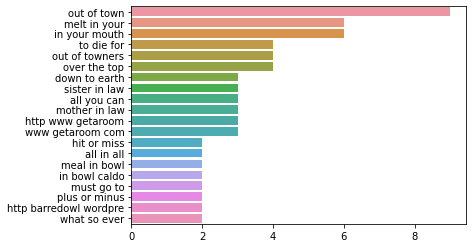

In [20]:
plot_top_ngrams_barchart(fakeReviews['reviewContent'],3)

In [21]:
fake_df = restaurant_reviews[restaurant_reviews['flagged'] == 'Y']["reviewerID"].to_frame()
true_df = restaurant_reviews[restaurant_reviews['flagged'] == 'N']["reviewerID"].to_frame()
print("Fake Reviewers " + str(len(fake_df["reviewerID"].unique())))
print("True Reviewers " + str(len(true_df["reviewerID"].unique())))
print("True and Fake Reviewers " + str(len(list(set(fake_df["reviewerID"].unique()) & set(true_df["reviewerID"].unique())))))

Fake Reviewers 7118
True Reviewers 28049
True and Fake Reviewers 138


In [22]:
full_rest_df = pd.merge(restaurant_reviews, restaurant_reviewers, on="reviewerID")
fake_df = full_rest_df[full_rest_df['flagged'] == 'Y']["firstCount"]
true_df = full_rest_df[full_rest_df['flagged'] == 'N']["firstCount"]
print("Fake stats Counts " + str(fake_df.count()) + str(" Sum ") + str(fake_df.sum()))
print("True stats Counts " + str(true_df.count()) + str(" Sum ") + str(true_df.sum()))

Fake stats Counts 6206 Sum 1549
True stats Counts 20752 Sum 225700


# Part 3: Model Training

## Preparing for the word embeddings

In [23]:
# GloVe Embeddings
# Download the GloVe embeddings
if 'embedding' not in os.listdir('.') or not os.listdir('embedding'):
    os.system('wget http://nlp.stanford.edu/data/glove.6B.zip -P embedding/')
    os.system('cd embedding && unzip glove.6B.zip')
    print('Data the GloVe embedding successfully!')
else:
    print('Already downloaded the embedding')
    
# Use the 100 dimensional GloVe embedding
path_to_glove_file = "./embedding/glove.6B.300d.txt"

glove_dimension = 300
glove_embedding_map = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_embedding_map[word] = coefs

print("Found %s word vectors." % len(glove_embedding_map))

def get_glove_embedding(word):
    return glove_embedding_map.get(word.strip(), None)


Already downloaded the embedding
Found 400000 word vectors.


In [24]:
# Pre-trained Elmo
elmo = hub.load("https://tfhub.dev/google/elmo/3")

def get_elmo_embedding(words):
    return elmo.signatures['default'](tf.constant(words))['elmo']


2021-11-27 00:05:19.604202: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Model 1: GloVe Embedding + Plain LSTM

In [25]:
def build_model_1_hotel(num_epochs=2, sequence_length=50):
    
    # First layer, vectorizing the word input
    m1_hotel_vectorizer = TextVectorization(output_sequence_length=sequence_length)
    m1_hotel_vectorizer.adapt(hotel_X_train['reviewContent'].to_numpy())
    m1_hotel_voc = m1_hotel_vectorizer.get_vocabulary()

    print(f"Model 1: Hotels reviews vocabulary size is {len(m1_hotel_voc)}")

    # Build + Lock in the Embedding layer from GloVe
    # Ref: https://keras.io/examples/nlp/pretrained_word_embeddings/
    hits = 0
    misses = 0
    num_words = len(m1_hotel_voc)

    # Prepare embedding matrix
    m1_hotel_embedding_matrix = np.zeros((num_words, glove_dimension))
    for i, word in enumerate(m1_hotel_voc):
        embedding_vector = get_glove_embedding(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            m1_hotel_embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    m1_hotel_embedding_layer = Embedding(
        num_words,
        glove_dimension,
        embeddings_initializer=tf.keras.initializers.Constant(m1_hotel_embedding_matrix),
        trainable=False,
    )

    # Vectorize the input
    hotel_X_train_ready = m1_hotel_vectorizer(hotel_X_train['reviewContent']).numpy()
    hotel_X_dev_ready = m1_hotel_vectorizer(hotel_X_dev['reviewContent']).numpy()
    hotel_X_test_ready = m1_hotel_vectorizer(hotel_X_test['reviewContent']).numpy()
    print(f'training set shape: {hotel_X_train_ready.shape}')

    # Build and train the model with 
    model = Sequential(name='model_1_hotel')
    model.add(m1_hotel_embedding_layer)
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(model.summary())
    model.fit(hotel_X_train_ready, hotel_y_train, epochs=num_epochs)

    # Evaluate on the dev set
    hotel_y_predicted = model.predict(hotel_X_dev_ready)
    print(classification_report(hotel_y_predicted > 0.5, hotel_y_dev))
    print('Dev set class distribution')
    print(hotel_X_dev['flagged'].value_counts() / len(hotel_X_dev))

    # Evaluate on the test set
    hotel_y_predicted = model.predict(hotel_X_test_ready)
    print(classification_report(hotel_y_predicted > 0.5, hotel_y_test))
    print('Test set class distribution')
    print(hotel_X_test['flagged'].value_counts() / len(hotel_X_test))
    
build_model_1_hotel()

Model 1: Hotels reviews vocabulary size is 19218
Converted 14701 words (4517 misses)
training set shape: (3402, 50)
Model: "model_1_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         5765400   
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 5,858,905
Trainable params: 93,505
Non-trainable params: 5,765,400
_________________________________________________________________
None
Epoch 1/2
107/107 [==============================] - 7s 46ms/step - loss: 0.3858 - accuracy: 0.8704
Epoch 2/2
107/107 [==============================] - 5s 42ms/step - loss: 0.3642 

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.87      0.93      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.87      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.87      0.93      1134

Dev set class distribution
N    0.872134
Y    0.127866
Name: flagged, dtype: float64
              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

## Model 2 - Data Resampling + GloVe Embedding + LSTM

In [26]:
# Split the positive/negative samples for more balanced sampling
hotel_X_train_positive = hotel_X_train[hotel_X_train['flagged'] == 'Y']
hotel_X_train_negative = hotel_X_train[hotel_X_train['flagged'] == 'N']

print(f'There are {len(hotel_X_train_positive)} positive examples')
print(f'There are {len(hotel_X_train_negative)} negative examples')

def build_model_2_hotel(num_epochs=2, sequence_length=50, resample_ratio=0.5):

    # First layer, vectorizing the word input
    m2_hotel_vectorizer = TextVectorization(output_sequence_length=sequence_length)
    m2_hotel_vectorizer.adapt(hotel_X_train['reviewContent'].to_numpy())
    m2_hotel_voc = m2_hotel_vectorizer.get_vocabulary()

    print(f"Model 1: Hotels reviews vocabulary size is {len(m2_hotel_voc)}")

    # Build + Lock in the Embedding layer from GloVe
    # Ref: https://keras.io/examples/nlp/pretrained_word_embeddings/
    hits = 0
    misses = 0
    num_words = len(m2_hotel_voc)

    # Prepare embedding matrix
    m2_hotel_embedding_matrix = np.zeros((num_words, glove_dimension))
    for i, word in enumerate(m2_hotel_voc):
        embedding_vector = get_glove_embedding(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            m2_hotel_embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    m2_hotel_embedding_layer = Embedding(
        num_words,
        glove_dimension,
        embeddings_initializer=tf.keras.initializers.Constant(m2_hotel_embedding_matrix),
        trainable=False,
    )
    
    # Oversample some positive training samples
    num_negative_samples = len(hotel_X_train_negative)
    positive_ratio = resample_ratio
    hotel_positives = hotel_X_train_positive.sample(n=int(num_negative_samples * positive_ratio), replace=True).reset_index(drop=True)
    hotel_negatives = hotel_X_train_negative

    hotel_X_train_balanced = pd.concat([hotel_positives, hotel_negatives], ignore_index=True).sample(frac=1)
    hotel_y_train_balanced = hotel_X_train_balanced['flagged'] == 'Y'
    
    # Vectorize the input
    hotel_X_train_ready = m2_hotel_vectorizer(hotel_X_train_balanced['reviewContent']).numpy()
    hotel_X_dev_ready = m2_hotel_vectorizer(hotel_X_dev['reviewContent']).numpy()
    hotel_X_test_ready = m2_hotel_vectorizer(hotel_X_test['reviewContent']).numpy()
    print(f'training set shape: {hotel_X_train_ready.shape}')

    # Build and train the model with 
    model = Sequential(name='model_2_hotel')
    model.add(m2_hotel_embedding_layer)
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(model.summary())
    model.fit(hotel_X_train_ready, hotel_y_train_balanced, epochs=num_epochs)

    # Evaluate on the dev set
    hotel_y_predicted = model.predict(hotel_X_dev_ready)
    print(classification_report(hotel_y_predicted > 0.5, hotel_y_dev))
    print('Dev set class distribution')
    print(hotel_X_dev['flagged'].value_counts() / len(hotel_X_dev))

    # Evaluate on the test set
    hotel_y_predicted = model.predict(hotel_X_test_ready)
    print(classification_report(hotel_y_predicted > 0.5, hotel_y_test))
    print('Test set class distribution')
    print(hotel_X_test['flagged'].value_counts() / len(hotel_X_test))
    
build_model_2_hotel(resample_ratio=1)



There are 416 positive examples
There are 2986 negative examples
Model 1: Hotels reviews vocabulary size is 19218
Converted 14701 words (4517 misses)
training set shape: (5972, 50)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         5765400   
                                                                 
 lstm_1 (LSTM)               (None, 64)                93440     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,858,905
Trainable params: 93,505
Non-trainable params: 5,765,400
_________________________________________________________________
None
Epoch 1/2
187/187 [==============================] - 10s 43ms/step - loss: 0.6657 - accuracy: 0.5953
Epoch 2/2
187/1

# Model 3: Train with generated fake reviews on LSTM

In [27]:
# Generating fake reviews from gpt-2 based on the training fake review set.
# Catherine ran it in an AWS instance and it takes a really long time.
# Commenting out the code to not run over and over again.
##########################
# !pip install transformers
# !pip install torch

# hotel_reviews_fake = hotel_X_train[hotel_X_train['flagged'] == 'Y']
# np.savetxt(r'data/hotel_fake.txt', hotel_reviews_fake['reviewContent'].values, fmt='%s')

# !python gpt2_fine_tuning.py \
#     --output_dir hotel \
#     --model_name_or_path=gpt2 \
#     --do_train \
#     --train_data_file='./data/hotel_fake.txt' \
#     --per_gpu_train_batch_size=1

# !python gpt2_generation.py \
#     --model_name_or_path hotel \
#     --length=10 \
#     --seed=3

In [28]:
# Load more generated fake reviews for model 3:
# Load in previous generated fake reviews
with open('generated_hotel_fake.txt') as f:
    lines = f.read().splitlines()
    hotel_X_train_positive_generated = pd.DataFrame({'reviewContent':lines, 'flagged': 'Y'})

def build_model_3_hotel(num_epochs=2, sequence_length=50):
    # Add generated fake reviews into the training set
    hotel_X_train_positive = hotel_X_train[hotel_X_train['flagged'] == 'Y']
    hotel_X_train_negative = hotel_X_train[hotel_X_train['flagged'] == 'N']

    print(f'There are {len(hotel_X_train_positive)} positive examples')
    print(f'There are {len(hotel_X_train_positive_generated)} generated positive examples')
    print(f'There are {len(hotel_X_train_negative)} negative examples')

    num_positive_needed = len(hotel_X_train_negative) - len(hotel_X_train_positive)
    hotel_X_train_positive_generated_sampled = hotel_X_train_positive_generated.sample(n=num_positive_needed)
    hotel_X_train_all_positive = pd.concat([hotel_X_train_positive, hotel_X_train_positive_generated_sampled], ignore_index=True)
    hotel_X_train_balanced = pd.concat([hotel_X_train_all_positive, hotel_X_train_negative], ignore_index=True).sample(frac=1)
    hotel_y_train_balanced = hotel_X_train_balanced['flagged'] == 'Y'

    print(f"Training samples: {sum(hotel_X_train_balanced['flagged'] == 'Y')} positive, {sum(hotel_X_train_balanced['flagged'] == 'N')} negative")

    # For model 3, have to re-do the embedding again:
    m3_hotel_vectorizer = TextVectorization(output_sequence_length=sequence_length)
    m3_hotel_vectorizer.adapt(hotel_X_train_balanced['reviewContent'].to_numpy())
    m3_hotel_voc = m3_hotel_vectorizer.get_vocabulary()
    print(f"Model 3: Hotels reviews vocabulary size is {len(m3_hotel_voc)}")

    # Build + Lock in the Embedding layer from GloVe again
    hits = 0
    misses = 0
    num_words = len(m3_hotel_voc)

    # Prepare embedding matrix
    m3_hotel_embedding_matrix = np.zeros((num_words, glove_dimension))
    for i, word in enumerate(m3_hotel_voc):
        embedding_vector = get_glove_embedding(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            m3_hotel_embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    m3_hotel_embedding_layer = Embedding(
        num_words,
        glove_dimension,
        embeddings_initializer=tf.keras.initializers.Constant(m3_hotel_embedding_matrix),
        trainable=False,
    )

    # Vectorize the input
    hotel_X_train_ready = m3_hotel_vectorizer(hotel_X_train_balanced['reviewContent']).numpy()
    hotel_X_dev_ready = m3_hotel_vectorizer(hotel_X_dev['reviewContent']).numpy()
    hotel_X_test_ready = m3_hotel_vectorizer(hotel_X_test['reviewContent']).numpy()
    print(f'training set shape: {hotel_X_train_ready.shape}')

    # Build and train the model with 
    model = Sequential(name='model_3_hotel')
    model.add(m3_hotel_embedding_layer)
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(model.summary())
    model.fit(hotel_X_train_ready, hotel_y_train_balanced, epochs=num_epochs)

    # Evaluate on the dev set
    hotel_y_predicted = model.predict(hotel_X_dev_ready)
    print(classification_report(hotel_y_predicted > 0.5, hotel_y_dev))
    print('Dev set class distribution')
    print(hotel_X_dev['flagged'].value_counts() / len(hotel_X_dev))

    # Evaluate on the test set
    hotel_y_predicted = model.predict(hotel_X_test_ready)
    print(classification_report(hotel_y_predicted > 0.5, hotel_y_test))
    print('Test set class distribution')
    print(hotel_X_test['flagged'].value_counts() / len(hotel_X_test))
    
build_model_3_hotel(num_epochs=10)


There are 416 positive examples
There are 3821 generated positive examples
There are 2986 negative examples
Training samples: 2986 positive, 2986 negative
Model 3: Hotels reviews vocabulary size is 22659
Converted 16721 words (5938 misses)
training set shape: (5972, 50)
Model: "model_3_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 300)         6797700   
                                                                 
 lstm_2 (LSTM)               (None, 64)                93440     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,891,205
Trainable params: 93,505
Non-trainable params: 6,797,700
_________________________________________________________________
None
Epoch 1/10
187/187 [======

# Model 4: Training with generated fake reviews on BERT

In [29]:
# Train BERT
import tensorflow_text as text 
def build_model_4_hotel(num_epochs=1):
    # Add generated fake reviews into the training set
    hotel_X_train_positive = hotel_X_train[hotel_X_train['flagged'] == 'Y']
    hotel_X_train_negative = hotel_X_train[hotel_X_train['flagged'] == 'N']

    print(f'There are {len(hotel_X_train_positive)} positive examples')
    print(f'There are {len(hotel_X_train_positive_generated)} generated positive examples')
    print(f'There are {len(hotel_X_train_negative)} negative examples')

    num_positive_needed = len(hotel_X_train_negative) - len(hotel_X_train_positive)
    hotel_X_train_positive_generated_sampled = hotel_X_train_positive_generated.sample(n=num_positive_needed)
    hotel_X_train_all_positive = pd.concat([hotel_X_train_positive, hotel_X_train_positive_generated_sampled], ignore_index=True)
    hotel_X_train_balanced = pd.concat([hotel_X_train_all_positive, hotel_X_train_negative], ignore_index=True).sample(frac=1)
    hotel_y_train_balanced = hotel_X_train_balanced['flagged'] == 'Y'

    print(f"Training samples: {sum(hotel_X_train_balanced['flagged'] == 'Y')} positive, {sum(hotel_X_train_balanced['flagged'] == 'N')} negative")

    # BERT has its own input and preprocessing
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
    preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_preprocess/3")
    encoder_inputs = preprocessor(text_input)
    encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1", trainable=True)
    outputs = encoder(encoder_inputs)

    net = outputs['pooled_output']
    net = Dropout(0.2)(net)
    net = Dense(1, activation='sigmoid', name='model_4_hotel')(net)
    model = tf.keras.Model(text_input, net)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())

    model.fit(hotel_X_train_balanced['reviewContent'], hotel_y_train_balanced, epochs=num_epochs)

    # Evaluate on the dev set
    hotel_y_predicted = model.predict(hotel_X_dev['reviewContent'])
    print(classification_report(hotel_y_predicted > 0.5, hotel_y_dev))
    print('Dev set class distribution')
    print(hotel_X_dev['flagged'].value_counts() / len(hotel_X_dev))

    # Evaluate on the test set
    hotel_y_predicted = model.predict(hotel_X_test['reviewContent'])
    print(classification_report(hotel_y_predicted > 0.5, hotel_y_test))
    print('Test set class distribution')
    print(hotel_X_test['flagged'].value_counts() / len(hotel_X_test))
    
build_model_4_hotel()


There are 416 positive examples
There are 3821 generated positive examples
There are 2986 negative examples
Training samples: 2986 positive, 2986 negative
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['input_1[0][0]']                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'inpu

# Model 5: Training with generated fake reviews on BERT with Elmo embedding

In [30]:
def build_model_5_hotel(num_epochs=2, sequence_length=50):
    # Add generated fake reviews into the training set
    hotel_X_train_positive = hotel_X_train[hotel_X_train['flagged'] == 'Y']
    hotel_X_train_negative = hotel_X_train[hotel_X_train['flagged'] == 'N']

    print(f'There are {len(hotel_X_train_positive)} positive examples')
    print(f'There are {len(hotel_X_train_positive_generated)} generated positive examples')
    print(f'There are {len(hotel_X_train_negative)} negative examples')

    num_positive_needed = len(hotel_X_train_negative) - len(hotel_X_train_positive)
    hotel_X_train_positive_generated_sampled = hotel_X_train_positive_generated.sample(n=num_positive_needed)
    hotel_X_train_all_positive = pd.concat([hotel_X_train_positive, hotel_X_train_positive_generated_sampled], ignore_index=True)
    hotel_X_train_balanced = pd.concat([hotel_X_train_all_positive, hotel_X_train_negative], ignore_index=True).sample(frac=1)
    hotel_y_train_balanced = hotel_X_train_balanced['flagged'] == 'Y'

    print(f"Training samples: {sum(hotel_X_train_balanced['flagged'] == 'Y')} positive, {sum(hotel_X_train_balanced['flagged'] == 'N')} negative")


    m5_hotel_vectorizer = TextVectorization(output_sequence_length=sequence_length)
    m5_hotel_vectorizer.adapt(hotel_X_train_balanced['reviewContent'].to_numpy())
    m5_hotel_voc = m5_hotel_vectorizer.get_vocabulary()
    print(f"Model 5: Hotels reviews vocabulary size is {len(m5_hotel_voc)}")

    elmo_embeddings = get_elmo_embedding(m5_hotel_voc)

    # Building the embedding layer using Elmo results
    elmo_embedding_dim = 1024
    num_words = len(m5_hotel_voc)

    m5_hotel_embedding_matrix = np.zeros((num_words, elmo_embedding_dim))
    for i, word in enumerate(m5_hotel_voc):
        m5_hotel_embedding_matrix[i] = elmo_embeddings[i][0]

    m5_hotel_embedding_layer = Embedding(
        num_words,
        elmo_embedding_dim,
        embeddings_initializer=tf.keras.initializers.Constant(m5_hotel_embedding_matrix),
        trainable=False,
    )

    # Vectorize the input
    hotel_X_train_ready = m5_hotel_vectorizer(hotel_X_train_balanced['reviewContent']).numpy()
    hotel_X_dev_ready = m5_hotel_vectorizer(hotel_X_dev['reviewContent']).numpy()
    hotel_X_test_ready = m5_hotel_vectorizer(hotel_X_test['reviewContent']).numpy()
    print(f'training set shape: {hotel_X_train_ready.shape}')

    # Build and train the model with 
    model = Sequential(name='model_5_hotel')
    model.add(m5_hotel_embedding_layer)
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(model.summary())
    model.fit(hotel_X_train_ready, hotel_y_train_balanced, epochs=num_epochs)

    # Evaluate on the dev set
    hotel_y_predicted = model.predict(hotel_X_dev_ready)
    print(classification_report(hotel_y_predicted > 0.5, hotel_y_dev))
    print('Dev set class distribution')
    print(hotel_X_dev['flagged'].value_counts() / len(hotel_X_dev))

    # Evaluate on the test set
    hotel_y_predicted = model.predict(hotel_X_test_ready)
    print(classification_report(hotel_y_predicted > 0.5, hotel_y_test))
    print('Test set class distribution')
    print(hotel_X_test['flagged'].value_counts() / len(hotel_X_test))


build_model_5_hotel()


There are 416 positive examples
There are 3821 generated positive examples
There are 2986 negative examples
Training samples: 2986 positive, 2986 negative
Model 5: Hotels reviews vocabulary size is 22745
training set shape: (5972, 50)
Model: "model_5_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 1024)        23290880  
                                                                 
 lstm_3 (LSTM)               (None, 64)                278784    
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 23,569,729
Trainable params: 278,849
Non-trainable params: 23,290,880
_________________________________________________________________
None
Epoch 1/2
187/187 [==============================] - 19s 87

# 